# Detect Experimental Events

In [1]:
import sys
import os
import os.path as op
import numpy as np
import pandas as pd
sys.path.append("../")
from mne_path import PathHandler
ph = PathHandler()
from glob import glob
import random

import mne

%matplotlib inline

In [2]:
SAMPLE_DATA_DIR = ph.cddir(ph.SAMPLE_DIR)

# list of all fif files in sample data
FIF_FILES = sorted(glob(op.join(SAMPLE_DATA_DIR, "**/**/*.fif")))

print("Total FIF Files: ", len(FIF_FILES))
display(FIF_FILES[:5])

Changed to:  /Users/jonghang/mne_data/MNE-sample-data
Total FIF Files:  36


['/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/all-trans.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise-cov.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise_raw-eve.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis-ave.fif']

In [3]:
# sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = FIF_FILES[26]
fif_raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file /Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


# Clean Data using ICA

In [4]:
# load data
fif_raw.load_data()

ICA_METHOD_FAST_ICA = "fastica"
ICA_METHOD_PICARD = "picard"
ICA_METHOD_INFOMAX = "infomax"
ICA_METHOD_INFOMAX_EXT = "extended-infomax"

def get_ica(input_n_components, 
            ica_method = ICA_METHOD_FAST_ICA): 
    """
    Fit FIF raw data into ICA using fast ICA if 
    method is not specified
    """
    fifica = mne.preprocessing.ICA(n_components = input_n_components, 
                                    method = ica_method,
                                    random_state = 13, 
                                    max_iter = 800)
    return fifica

# clean data
fif_ica = get_ica(input_n_components = 25,
                  ica_method = ICA_METHOD_FAST_ICA)

# Fit FIF Raw with ICA
fif_ica.fit(fif_raw.copy())

# Exclude the first component
fif_ica.exclude = [1]

fif_raw_cleaned = fif_ica.apply(fif_raw.copy())

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 3.2s.
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 364 PCA components


__Projection Items__

The Projection Items above are SSP projectors calculated to remove environmental noise from the MEG signals, plus a projector to mean-reference the EEG channels.  Details of these projections will be discussed in the future. 

In addition to the information displayed during loading, you can get a glimpse of the basic details of a Raw object by printing it; even more is available by printing its info attribute (a dictionary-like object that is preserved across Raw, Epochs, and Evoked objects). 

The info data structure keeps track of channel locations, applied filters, projectors, etc. Notice especially the chs entry, showing that MNE-Python detects different sensor types and handles each appropriately

# Detecting experimental events

The sample dataset includes several “STIM” channels that recorded electrical signals sent from the stimulus delivery computer (as brief DC shifts / squarewave pulses). These pulses (often called “triggers”) are used in this dataset to mark experimental events: stimulus onset, stimulus type, and participant response (button press). The individual STIM channels are combined onto a single channel, in such a way that voltage levels on that channel can be unambiguously decoded as a particular event type. On older Neuromag systems (such as that used to record the sample data) this summation channel was called STI 014, so we can pass that channel name to the mne.find_events function to recover the timing and identity of the stimulus events.

In [5]:
events = mne.find_events(fif_raw_cleaned, stim_channel='STI 014')

# show the first 5 events
display(events[:5]) 

319 events found
Event IDs: [ 1  2  3  4  5 32]


array([[6994,    0,    2],
       [7086,    0,    3],
       [7192,    0,    1],
       [7304,    0,    4],
       [7413,    0,    2]])

## Event IDs

Construct an event dictionary as the event_id parameter so that we can retrieve the event descriptions.

In [6]:
event_dict = {'auditory/left': 1, 
              'auditory/right': 2, 
              'visual/left': 3,
              'visual/right': 4, 
              'smiley': 5, 
              'buttonpress': 32}

The / character in the dictionary keys allows pooling across conditions by requesting partial condition descriptors (i.e., requesting 'auditory' will select all epochs with Event IDs 1 and 2; requesting 'left' will select all epochs with Event IDs 1 and 3). There is also a convenient plot_events function for visualizing the distribution of events across the duration of the recording (to make sure event detection worked as expected). Here we’ll also make use of the Info attribute to get the sampling frequency of the recording (so our x-axis will be in seconds instead of in samples).

# Plot Events

https://mne.tools/stable/generated/mne.viz.plot_events.html

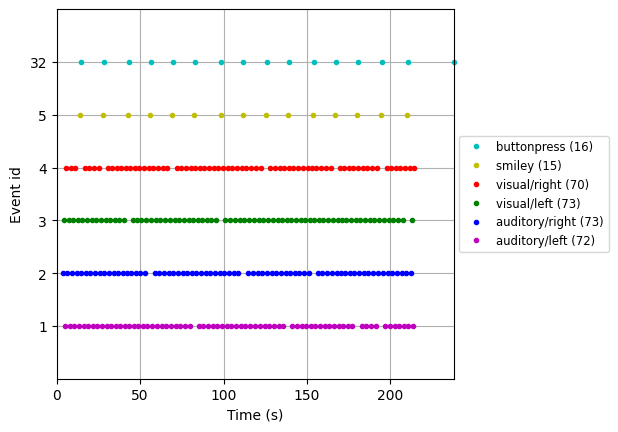

In [15]:
fig = mne.viz.plot_events(events, 
                          event_id = event_dict, 
                          sfreq = fif_raw.info['sfreq'],
                          first_samp = fif_raw_cleaned.first_samp,
                          color={1: 'm', 
                                  2: 'b', 
                                  3: 'g', 
                                  4: 'r', 
                                  5: 'y', 
                                  32: 'c'})

For paradigms that are not event-related (e.g., analysis of resting-state data), you can extract regularly spaced (possibly overlapping) spans of data by creating events using mne.make_fixed_length_events and then proceeding with epoching as described in the next section.

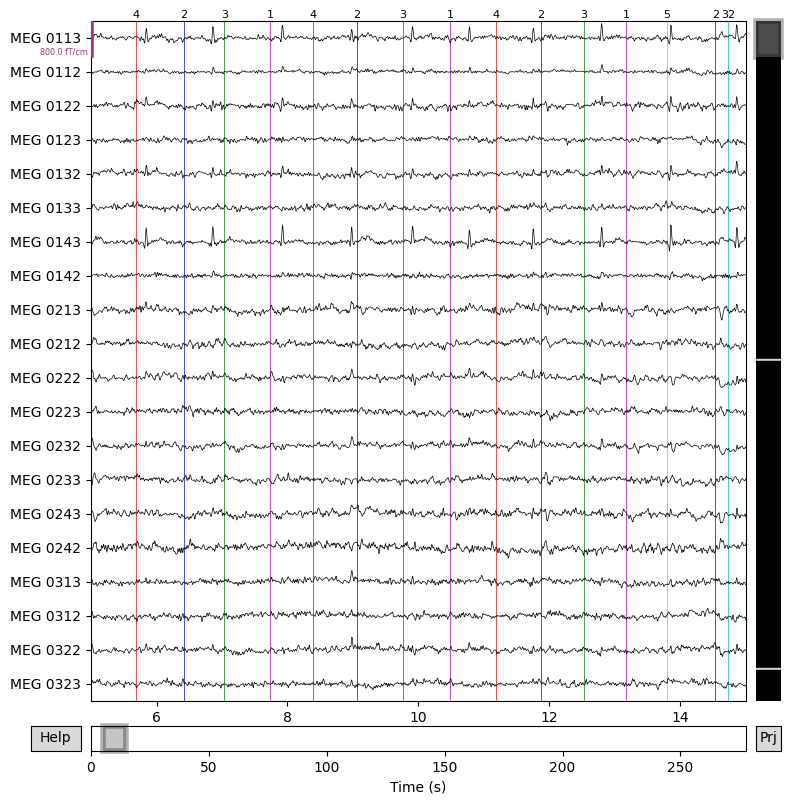

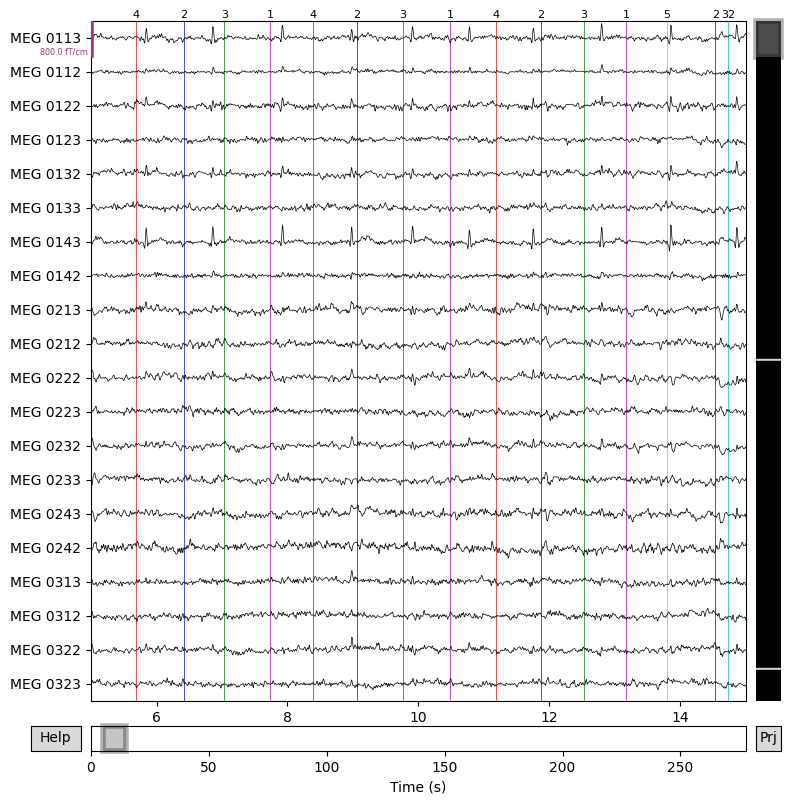

In [12]:
fif_raw_cleaned.plot(events = events, 
                     start = 5, duration = 10, 
                     color = 'black',
                     event_color={1: 'm', 
                                  2: 'b', 
                                  3: 'g', 
                                  4: 'r', 
                                  5: 'y', 
                                  32: 'c'})